In [1]:
%matplotlib inline

In [2]:
from collections import defaultdict

In [3]:
from kid_readout.measurement.io import npy
from kid_readout.measurement import plot_basic
from kid_readout.analysis.resonator import lmfit_resonator

In [4]:
plot_directory = '/home/flanigan/temp/'

In [5]:
npd = npy.NumpyDirectory('/data/detectors/2017-03-07_164552_scan.npd/')

In [6]:
sweeps = [npd.read(name) for name in npd.node_names() if name.startswith('SweepArray')]

In [7]:
snaps = [npd.read(name) for name in npd.node_names() if name.startswith('ADCSnap')]

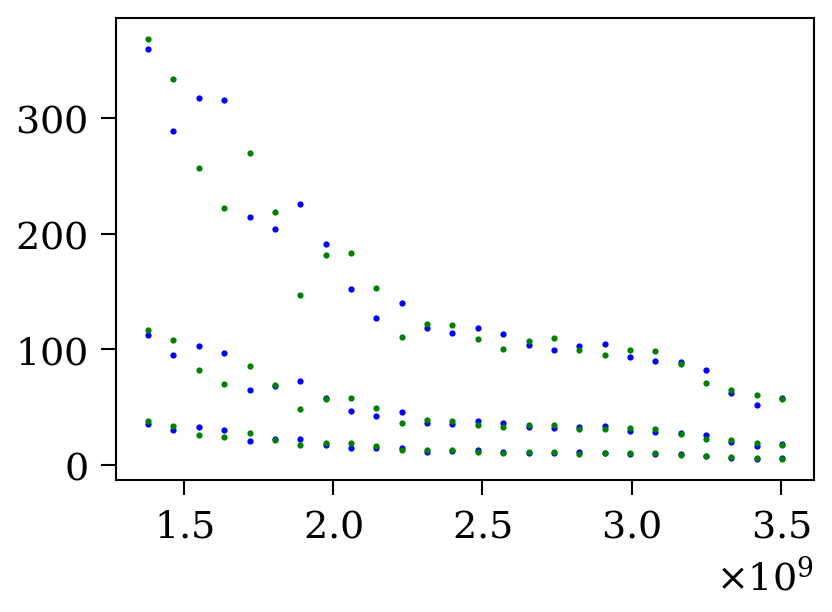

In [8]:
fig, ax = plt.subplots()
for sweep, snap in zip(sweeps, snaps):
    ax.plot(sweep.frequency.mean(), snap.x.std(), '.b')
    ax.plot(sweep.frequency.mean(), snap.y.std(), '.g')

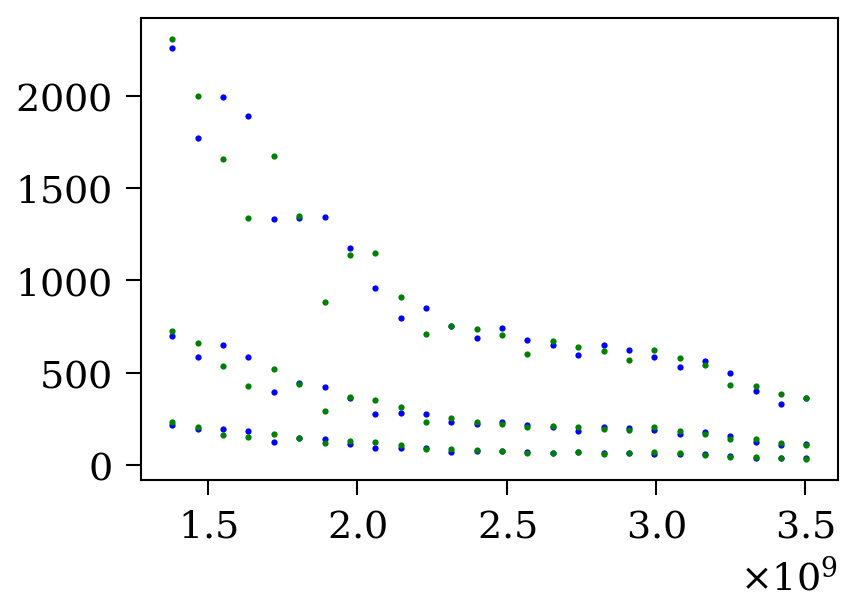

In [9]:
fig, ax = plt.subplots()
for sweep, snap in zip(sweeps, snaps):
    ax.plot(sweep.frequency.mean(), snap.x.ptp(), '.b')
    ax.plot(sweep.frequency.mean(), snap.y.ptp(), '.g')

# Organize data

In [10]:
sweep_dict = defaultdict(list)
for sweep in sweeps:
    sweep_dict[sweep.stream_arrays[0].roach_state.dac_attenuation].append(sweep)

# Nominal resonances

In [11]:
f_nominal = 1e9 * np.array([1.97, 2.38, 2.78, 3.19])
f_resonance = np.array([1437e6, 1643e6, 2019e6, 2394e6, 2956e6, 3340e6])

# Remove background

In [12]:
def remove_background(f, s21, amp_degree=4, phi_degree=4, weights=None):
    if weights is None:
        weights = np.abs(s21)**2
    amp_poly = np.polyfit(f, np.abs(s21), deg=amp_degree, w=weights)
    phi_poly = np.polyfit(f, np.unwrap(np.angle(s21)), deg=phi_degree, w=weights)
    return s21 / (np.polyval(amp_poly, f) * np.exp(1j * np.polyval(phi_poly, f)))

# Stitch sweeps

In [13]:
attenuation = 10
sweeps = sweep_dict[attenuation]
n = sweeps[0].frequency.size
overlap = int(n / 2)
left_weight = np.linspace(1, 0, overlap)
right_weight = np.linspace(0, 1, overlap)
frequencies = [sweeps[0].frequency[:overlap]]
amplitudes = [np.abs(sweeps[0].s21_point[:overlap])]
for left, right in zip(sweeps[:-1], sweeps[1:]):
    frequencies.append(left.frequency[overlap:])
    amplitudes.append(left_weight * np.abs(left.s21_point[overlap:]) +
                      right_weight * np.abs(right.s21_point[:overlap]))
frequencies.append(sweeps[-1].frequency[overlap:])
amplitudes.append(np.abs(sweeps[-1].s21_point[overlap:]))
frequency = np.concatenate(frequencies)
amplitude = np.concatenate(amplitudes)
width = int(n / 10)
kernel = np.exp(-np.linspace(-4, 4, width) ** 2)
kernel /= kernel.sum()
smoothed = np.convolve(kernel, amplitude, mode='same')
smoothed[:width] = smoothed[width + 1]
smoothed[-width:] = smoothed[-(width + 1)]

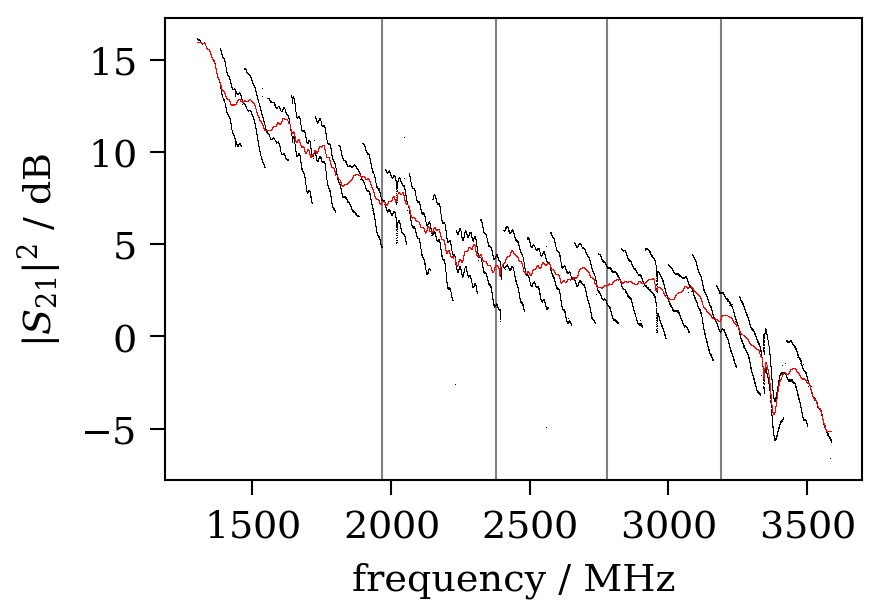

In [14]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / MHz')
ax.set_ylabel('$|S_{21}|^2$ / dB')

for f in f_nominal:
    ax.axvline(1e-6 * f, color='gray')
for sweep in sweeps:
    ax.plot(sweep.frequency_MHz, 20 * np.log10(np.abs(sweep.s21_point)), ',k')
ax.plot(1e-6 * frequency, 20 * np.log10(np.abs(smoothed)), ',r')

In [15]:
abs_poly = np.polyfit(frequency, np.abs(smoothed), deg=5)

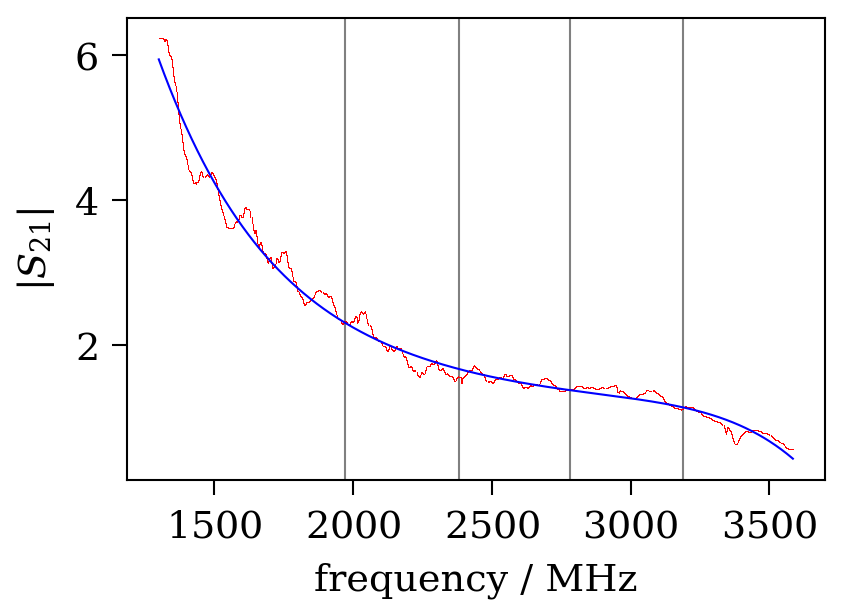

In [16]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / MHz')
ax.set_ylabel('$|S_{21}|$')
for f in f_nominal:
    ax.axvline(1e-6 * f, color='gray')
ax.plot(1e-6 * frequency, np.abs(smoothed), ',r')
ax.plot(1e-6 * frequency, np.polyval(abs_poly, frequency), '-b')

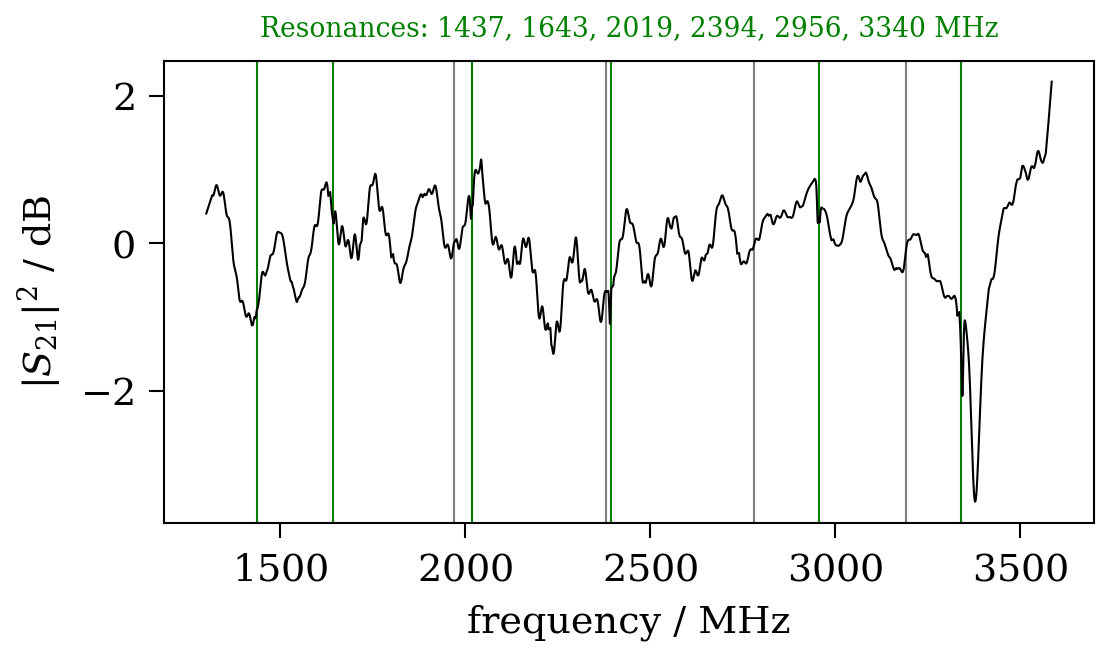

In [26]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.set_xlabel('frequency / MHz')
ax.set_ylabel('$|S_{21}|^2$ / dB')
for f in f_nominal:
    ax.axvline(1e-6 * f, color='gray')
for f in f_resonance:
    ax.axvline(1e-6 * f, color='green')
ax.plot(1e-6 * frequency, 20 * np.log10(np.abs(smoothed) / np.polyval(abs_poly, frequency)), '-k')
ax.set_title('Resonances: ' + ', '.join(['{:.0f}'.format(1e-6 * f) for f in f_resonance]) + ' MHz',
             color='green', fontsize='xx-small')

fig.savefig(plot_directory + 's21_vs_frequency_resonances_nominal_and_found.pdf')